<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/03_smoothing_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding smoothing metrics**

MAD results were not convincing enough. Indeed, values only started to decline after 10 layers, but we know that accuracy plunges after 2 layers.

### **Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from typing import Tuple, Dict, List
from torch_geometric.utils import to_dense_adj
from tqdm import tqdm

%matplotlib inline
sns.set_style('darkgrid')

## **Defining metrics**

$$
L = D - A
\\
\bar{L} = D^{-1/2} L D^{-1/2}
$$
A new metric, the __Dirichlet Energy__:
$$
h^T L h = \frac{1}{2} \sum_{i,j} a_{ij} (h_i - h_j)^2
$$

And the __Normalized Dirichlet Energy__:
$$
h^T \bar{L} h = \frac{1}{2} \sum_{i,j} a_{ij} \left(\frac{h_i}{\sqrt{d_i}} - \frac{h_j}{d_j} \right)^2
$$

Where $a_{ij}$ are the coefficients of $A$ the adjacency matrix

In [4]:
A = to_dense_adj(G.edge_index).squeeze(0)
D = torch.diag(A.sum(dim=1).view(-1))
L = D - A

In [5]:
# normalized feature distance
d = torch.diag(A.sum(dim=1).view(-1)**(-1/2))
normalized_laplacian = torch.matmul( d, torch.matmul(L, d) )

In [6]:
def dirichlet_energy(L:torch.tensor, h:torch.tensor):
    """Computes the feature distance

    Args
        - L [num_nodes, num_nodes]: laplacian matrix L=D-A
        - h [num_nodes, hidden_dim]: hidden representation of the nodes
    
    :rtype: tensor [num_nodes, 1]
    """
    return torch.matmul(
        torch.matmul(h.transpose(0, 1), L),
        h
    ).squeeze(0).trace().item()

In [7]:
def mad_value(in_arr, mask_arr, distance_metric='cosine', digt_num=4, target_idx=None):
    """The numpy version for mad (able to compute quickly)

    Args:
        - in_arr [node_num, hidden_dim]: the node feature matrix
        - mask_arr [node_num, node_num]: the mask matrix of the target relations (is it the adjacency matrix?)
        - target_idx [1, 2, 3, ...n]: the nodes indices for which we calculate the mad value
    """

    dist_arr = pairwise_distances(in_arr, in_arr, metric=distance_metric)
    mask_dist = np.multiply(dist_arr, mask_arr)
    divide_arr = (mask_dist != 0).sum(1) + 1e-8
    
    node_dist = mask_dist.sum(1) / divide_arr
    if target_idx==None:
        mad = node_dist.mean()
    else:
        node_dist = np.multiply(node_dist,target_idx)
        mad = node_dist.sum()/((node_dist!=0).sum()+1e-8)

    try:
        mad = round(mad, digt_num)
    except:
        pass

    return mad

In [8]:
def mad_gap_value(in_arr, adj):
    """Simple version of the MADGap metric implementation

    Args:
        - in_arr [node_num, hidden_dim]: the node feature matrix
        - adj [node_num, node_num]: dense adjacency matrix
    """

    mad_neb = mad_value(in_arr=in_arr, mask_arr=adj)
    mad_rmt = mad_value(in_arr=in_arr, mask_arr=1-adj)

    return (mad_rmt - mad_neb).item()

In [ ]:
mad_gap_value(G.x, A)

0.12205952405929565

In [ ]:
mad_value(G.x, mask_arr=np.ones((G.num_nodes, G.num_nodes)))

0.9441

## **Designing the model: Vanilla GCN**

In [10]:
import time

from torch_geometric.nn import Sequential, GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class VanillaGCN(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, num_classes:int, dropout:float=0.5):
        super().__init__()
        self.conv_layers = self.create_layers(num_layers=num_layers, 
                                              num_features=num_features,
                                              num_classes=num_classes,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout)
        self.out_gcn = GCNConv(in_channels=hidden_dim, out_channels=num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)


    def create_layers(self, num_layers:int, num_features:int, num_classes:int, 
                      hidden_dim:int, dropout:float):
        if num_layers == 2:
            return Sequential("x, edge_index", [(GCNConv(in_channels=num_features, out_channels=hidden_dim), "x, edge_index -> x")])

        layers = []

        # first layer
        layers += [
                (GCNConv(in_channels=num_features, out_channels=hidden_dim), "x, edge_index -> x"),
                (torch.nn.ReLU(), "x -> x"),
                (torch.nn.Dropout(p=dropout), "x -> x")
        ]

        for k in range(1, num_layers-2):
            layers += [
                (GCNConv(in_channels=hidden_dim, out_channels=hidden_dim), "x, edge_index -> x"),
                (torch.nn.ReLU(), "x -> x"),
                (torch.nn.Dropout(p=dropout), "x -> x")
            ]
        
        # last layer
        layers += [
            (GCNConv(in_channels=hidden_dim, out_channels=hidden_dim), "x, edge_index -> x")
        ]
        return Sequential("x, edge_index", layers)


    def reset_parameters(self):
        self.conv_layers.reset_parameters()
        # self.out_gcn.reset_parameters()


    def forward(self, x, edge_index):
        h = self.conv_layers(x, edge_index)
        out = self.relu(h)
        out = self.dropout(out)
        out = self.out_gcn(out, edge_index)
        
        return h, self.log_softmax(out)

## **Monitoring over-smoothing**

In [221]:
def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
          data: type(G), edge_index) -> Tuple[torch.tensor, float]:
    
    model.train()
    optimizer.zero_grad()

    hidden_state, out = model(data.x, edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return hidden_state, loss

def evaluate(model: torch.nn.Module, data: type(G), edge_index) -> Dict[str, float]:
    model.eval()

    with torch.no_grad():
        h, logits = model(data.x, edge_index)
    
    outs = {}
    feat_dist = dirichlet_energy(normalized_laplacian, h)
    mad_gap = mad_gap_value(h, A)
    mad = mad_value(h, np.ones((G.num_nodes, G.num_nodes)))

    outs['feat_dist'] = feat_dist
    outs['mad'] = mad
    outs['mad_gap'] = mad_gap

    for key in ['train', 'val', 'test']:
        mask = data[f'{key}_mask']
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    return outs

def run(data: type(G), model: torch.nn.Module,
        edge_index,
        runs: int, epochs: int, lr: float,
        weight_decay: float,
        early_stopping: int = 0,
        verbose:bool=True,
        initialize:bool=True) -> Tuple[List[float], List[float], List[float]]:

    val_losses, accs, durations = [], [], []

    for _ in range(runs):
        data = data.to(device)
        model.to(device)
        if initialize:
            model.reset_parameters()
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                                     weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        t_start = time.perf_counter()

        best_val_loss = float('inf')
        val_loss_history, train_losses, test_accs, feat_dists = [], [], [], []

        for epoch in range(1, epochs+1):
            hidden_state, train_loss = train(model, optimizer, data, edge_index)

            eval_info = evaluate(model, data, edge_index)
            
            test_acc = eval_info['test_acc']
            val_loss_history.append(eval_info['val_loss'])
            train_losses.append(train_loss.item())
            test_accs.append(test_acc)
            feat_dists.append(eval_info["feat_dist"])
        
            # I don't understand what this is for...
            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
            
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = torch.tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break
            
            if epoch % 10 == 0 and verbose:
                print(f"Epoch: [{epoch} / {epochs}] | Loss: {train_loss} | Test accuracy: {test_acc} | Distance: {eval_info['feat_dist']}")

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = torch.tensor(val_losses), torch.tensor(accs), torch.tensor(durations)

    print(f"Val Loss: {loss.mean().item():.4f}, Test Accuracy: {acc.mean().item():.3f} ± {acc.std().item():.3f}, Duration: {duration.mean().item():.3f}")
    return train_losses, test_accs, feat_dists

In [12]:
config = dict(
    num_layers=2,
    hidden_dim=16,
    num_features=cora_dataset.num_features,
    num_classes=cora_dataset.num_classes,
    epochs=400,
    learning_rate=0.01,
    weight_decay=5e-4,
    early_stopping=0,
    runs=1
)

In [ ]:
NUM_LAYERS=2
HIDDEN_DIM=16
NUM_FEATURES=cora_dataset.num_features
NUM_CLASSES=cora_dataset.num_classes
EPOCHS=400
LR=0.01
WEIGHT_DECAY=5e-4
EARLY_STOPPING=0
RUNS=1

In [ ]:
metrics = pd.DataFrame({'test_acc': [], 'mad': [], 'mad_gap': [], 'feat_dist': [], 'layers': []})

idx = 0
for K in range(2, 15):
    model = VanillaGCN(num_layers=K, hidden_dim=HIDDEN_DIM, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

    for _ in range(3):
        _, _, _ = run(data=G, model=model, edge_index=G.edge_index,
                    runs=RUNS, epochs=200, lr=LR, weight_decay=WEIGHT_DECAY,
                    early_stopping=EARLY_STOPPING, verbose=False)
        
        eval_info = evaluate(model, G, G.edge_index)

        metrics.loc[idx] = {'test_acc': eval_info['test_acc'], 
                            'mad': eval_info['mad'], 
                            'mad_gap': eval_info['mad_gap'],
                            'feat_dist': eval_info['feat_dist'],
                            'layers': K}
        print(metrics.loc[idx])

        idx += 1

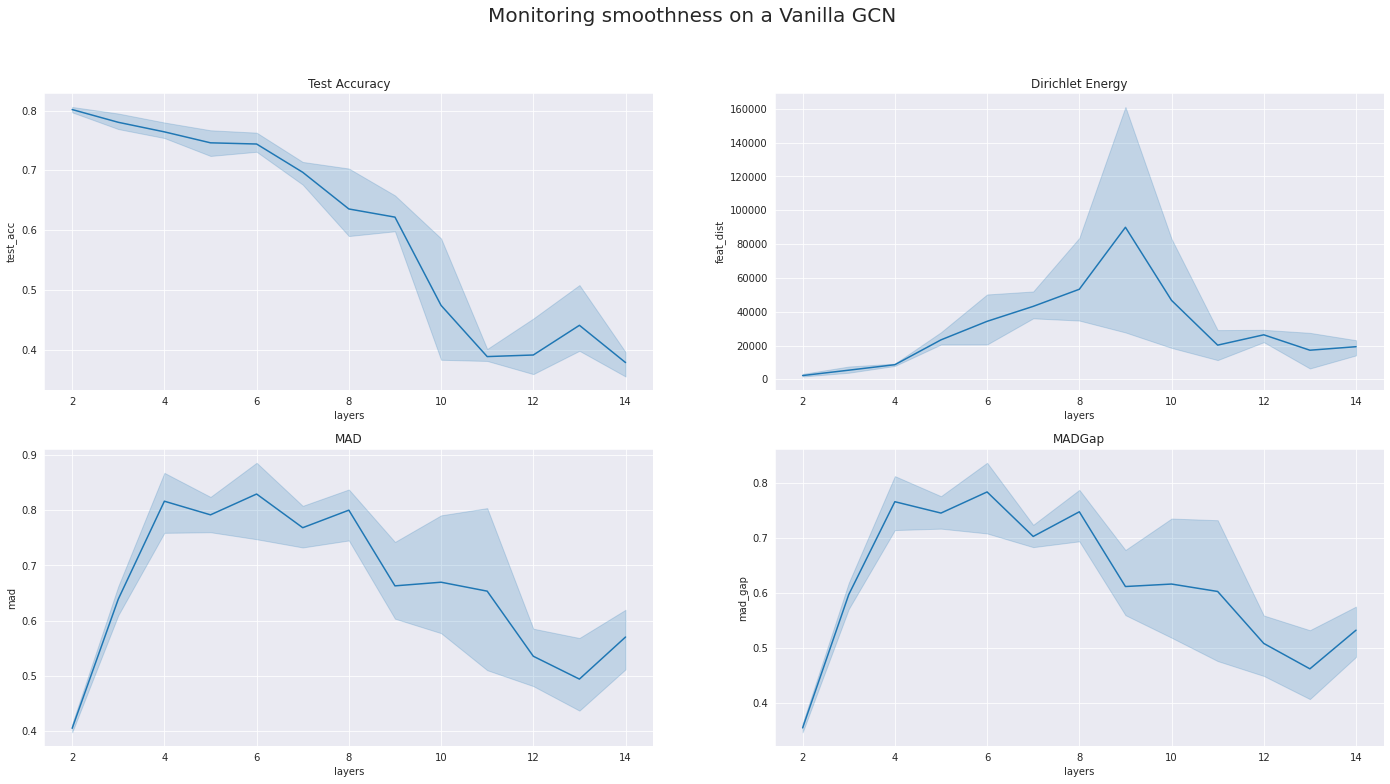

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12))

fig.suptitle("Monitoring smoothness on a Vanilla GCN", fontsize=20)

sns.lineplot(data=metrics, x='layers', y='test_acc', ax=ax[0, 0]).set(title="Test Accuracy")
sns.lineplot(data=metrics, x='layers', y='feat_dist', ax=ax[0, 1]).set(title="Dirichlet Energy")

sns.lineplot(data=metrics, x='layers', y='mad', ax=ax[1, 0]).set(title="MAD")
sns.lineplot(data=metrics, x='layers', y='mad_gap', ax=ax[1, 1]).set(title="MADGap")

fig.show()

## **Visualizing the hidden representations with t-SNE**

In [31]:
from sklearn.manifold import TSNE
palette = sns.color_palette("hls", config['num_classes'])

In [32]:
def tsne_plot(model: torch.nn.Module, title:str):
    # Representing the representations with t-SNE algorithm
    h, logits = model(G.x, G.edge_index)
    representations = TSNE().fit_transform(h.detach().numpy())
    
    # Plot the 2-D representations, both with true labels and predictions
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    fig.suptitle(title, fontsize=20)

    sns.scatterplot(x=representations[:,0], y=representations[:,1], hue=logits.argmax(dim=1), legend='full', palette=palette, ax=ax[0]).set(title="Predictions")
    sns.scatterplot(x=representations[:,0], y=representations[:,1], hue=G.y, legend='full', palette=palette, ax=ax[1]).set(title="True labels")
    
    fig.show()

### 2 Layers - 100 Epochs

In [ ]:
gcn_2_100 = VanillaGCN(num_layers=2, hidden_dim=16, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

train_loss, test_acc, feat_dists = run(data=G, model=gcn_2_100,
    edge_index=G.edge_index,
    runs=RUNS, epochs=100,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=EARLY_STOPPING,
    verbose=False)

Val Loss: 0.7032, Test Accuracy: 0.811 ± nan, Duration: 30.754


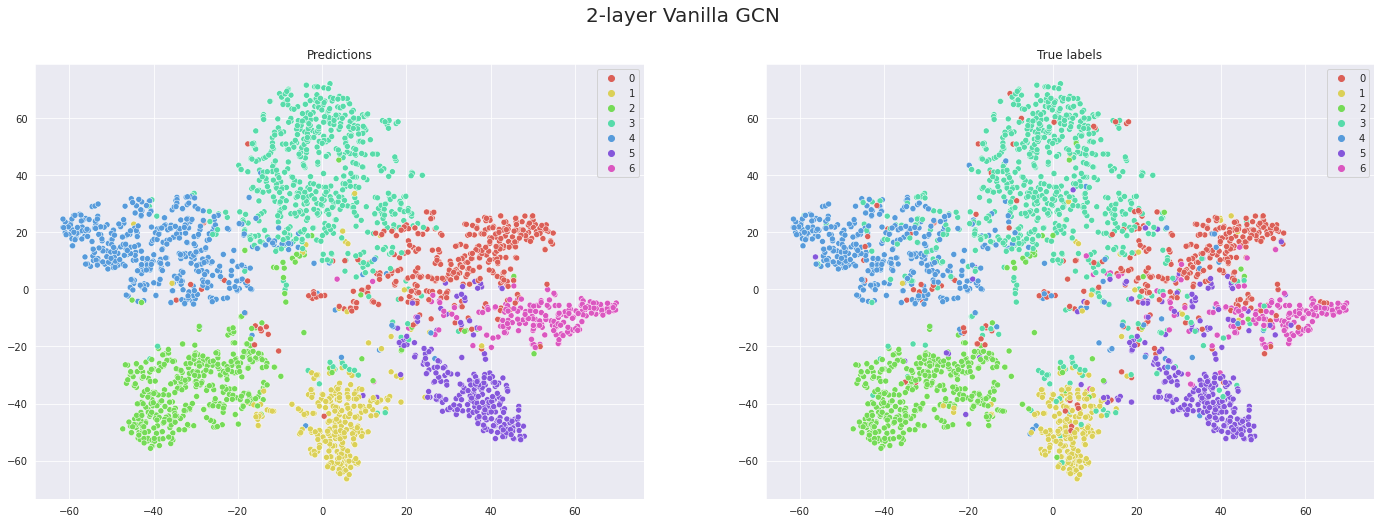

In [ ]:
tsne_plot(gcn_2_100, title="2-Layer GCN (100 epochs)")

### 2 Layers - 1000 Epochs

In [ ]:
gcn_2_1k = VanillaGCN(num_layers=2, hidden_dim=16, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

train_loss, test_acc, feat_dists = run(data=G, model=gcn_2_1k,
    edge_index=G.edge_index,
    runs=RUNS, epochs=1000,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=EARLY_STOPPING,
    verbose=False)

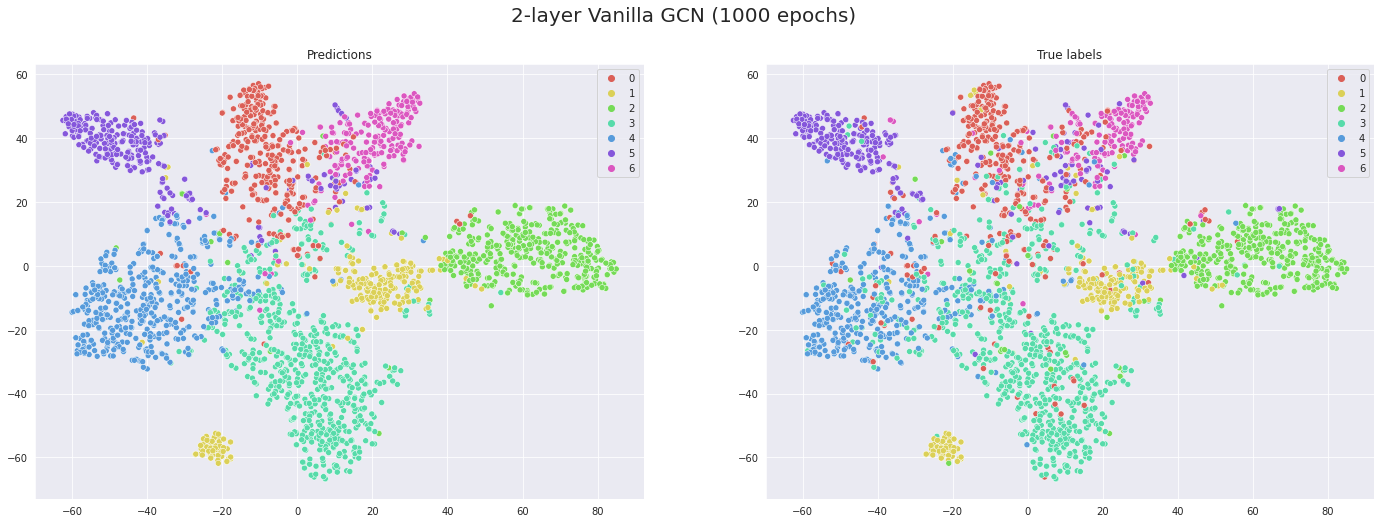

In [ ]:
tsne_plot(gcn_2_1k, title="2-Layer GCN (1000 epochs)")

### 2 Layers - 2000 Epochs

In [ ]:
gcn_2_2k = VanillaGCN(num_layers=2, hidden_dim=16, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

train_loss, test_acc, feat_dists = run(data=G, model=model,
    edge_index=G.edge_index,
    runs=RUNS, epochs=2000,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=EARLY_STOPPING,
    verbose=False)

Val Loss: 0.7466, Test Accuracy: 0.800 ± nan, Duration: 596.163


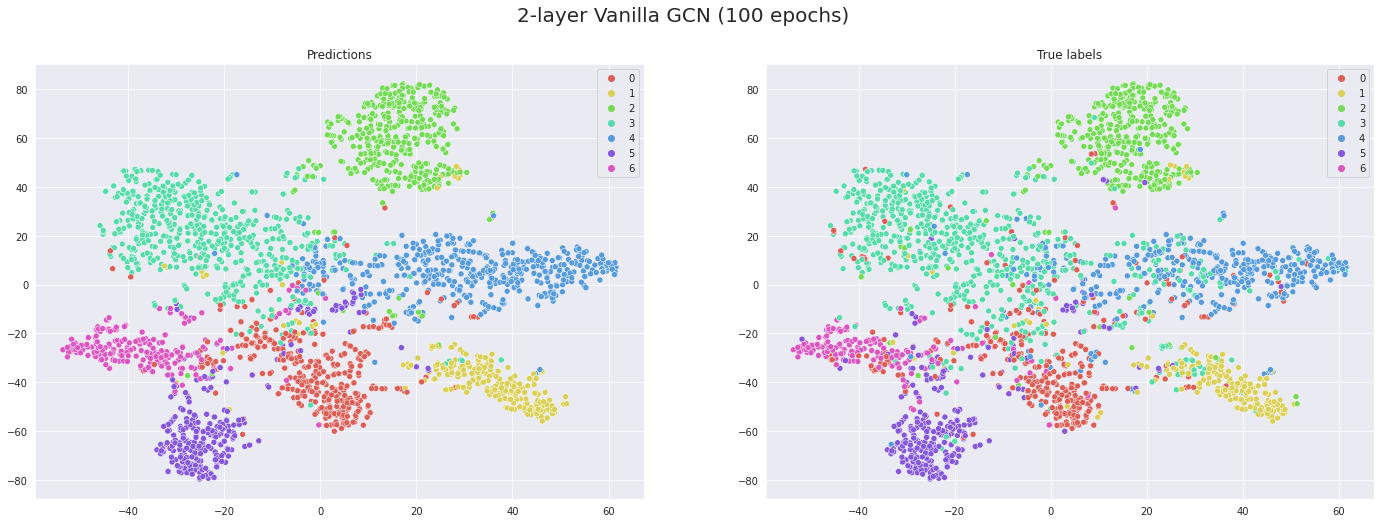

In [ ]:
tsne_plot(gcn_2_2k, title="2-Layer GCN (2000 epochs)")

### 6 Layers

In [ ]:
gcn_6_200 = VanillaGCN(num_layers=6, hidden_dim=16, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

train_loss, test_acc, feat_dists = run(data=G, model=gcn_6_200,
    edge_index=G.edge_index,
    runs=RUNS, epochs=200,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=EARLY_STOPPING,
    verbose=False)

Val Loss: 1.0584, Test Accuracy: 0.673 ± nan, Duration: 26.653


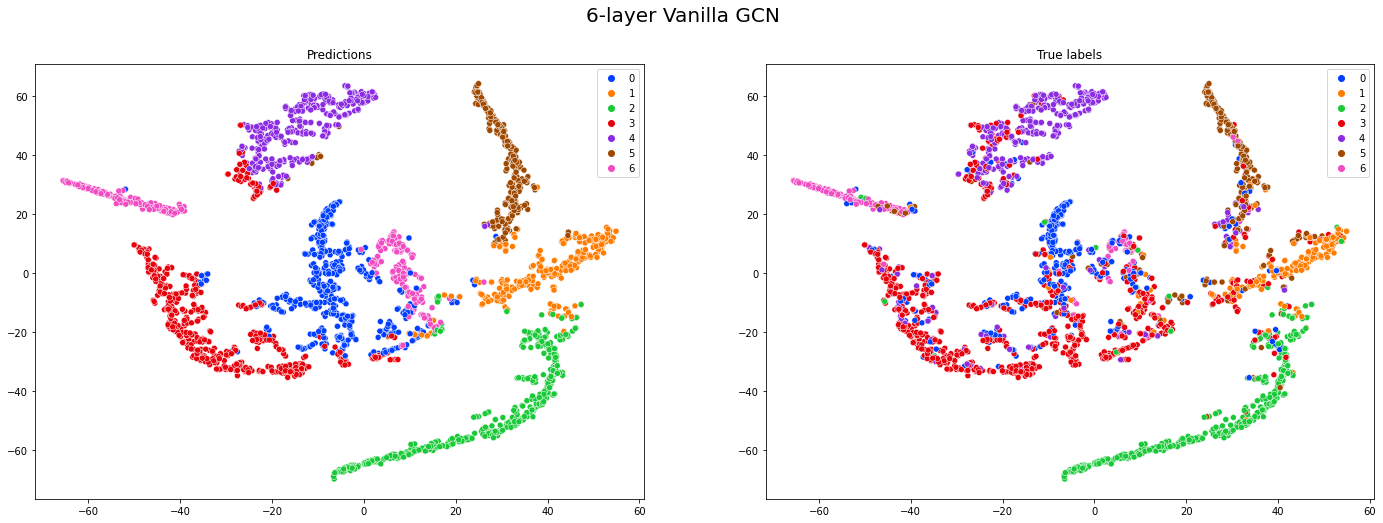

In [ ]:
tsne_plot(gcn_6_200, "6-Layer GCN (200 epochs)")

### 13 Layers

In [ ]:
gcn_13_200 = VanillaGCN(num_layers=13, hidden_dim=16, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

train_loss, test_acc, feat_dists = run(data=G, model=gcn_13_200,
    edge_index=G.edge_index,
    runs=RUNS, epochs=200,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=EARLY_STOPPING,
    verbose=False)

Val Loss: 1.4118, Test Accuracy: 0.369 ± nan, Duration: 37.708


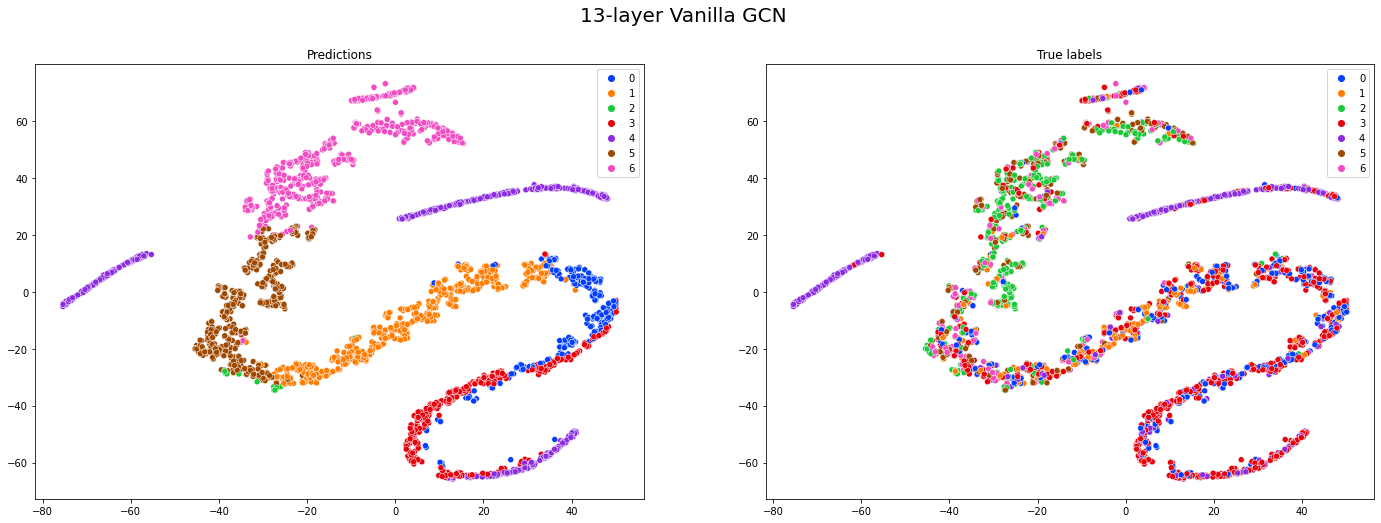

In [ ]:
tsne_plot(gcn_13_200, "13-Layer GCN (200 epochs)")

### Training a very deep model

Let's start with training a very very deep model (20 layers = diameter of the graph)

In [ ]:
NUM_LAYERS=20
HIDDEN_DIM=16
NUM_FEATURES=cora_dataset.num_features
NUM_CLASSES=cora_dataset.num_classes
EPOCHS=2000
LR=0.01
WEIGHT_DECAY=5e-4
EARLY_STOPPING=0
RUNS=1

In [ ]:
model = VanillaGCN(num_layers=NUM_LAYERS, hidden_dim=HIDDEN_DIM, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

In [ ]:
train_losses, test_accs, feat_dists = run(data=G, model=model, edge_index=G.edge_index,
                                          runs=RUNS, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY,
                                          early_stopping=EARLY_STOPPING, verbose=False)

Val Loss: 1.7641, Test Accuracy: 0.218 ± nan, Duration: 822.595


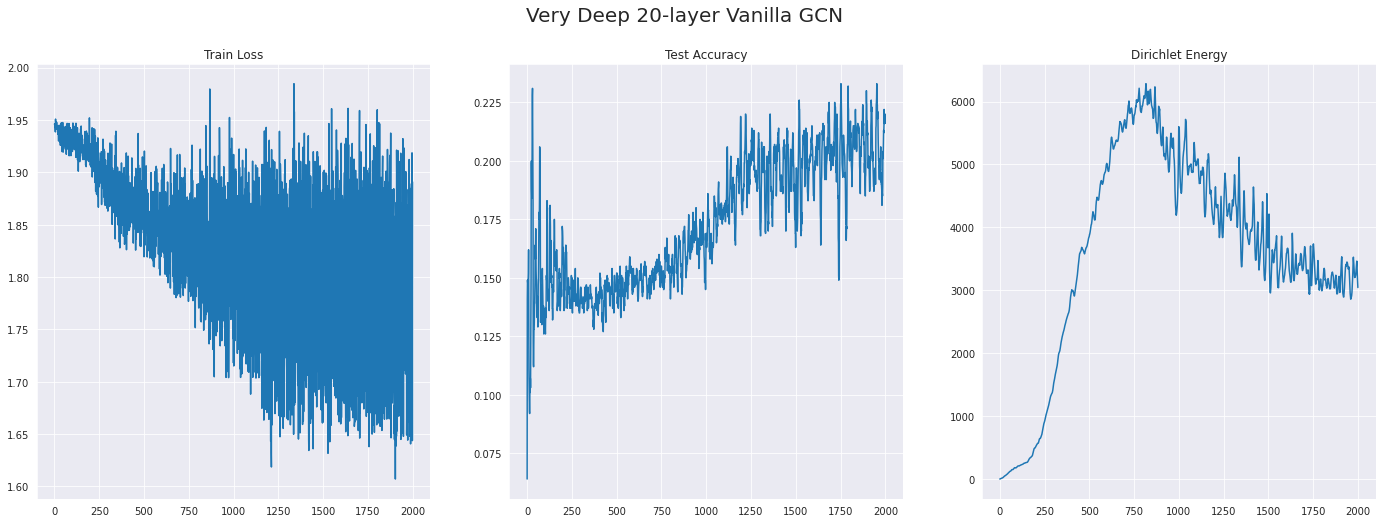

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

fig.suptitle(f"Very Deep {NUM_LAYERS}-layer Vanilla GCN", fontsize=20)

sns.lineplot(x=range(EPOCHS), y=train_losses, ax=ax[0]).set(title="Train Loss")
sns.lineplot(x=range(EPOCHS), y=test_accs, ax=ax[1]).set(title="Test Accuracy")
sns.lineplot(x=range(EPOCHS), y=feat_dists, ax=ax[2]).set(title="Dirichlet Energy")

fig.show()

Visualization with t-SNE

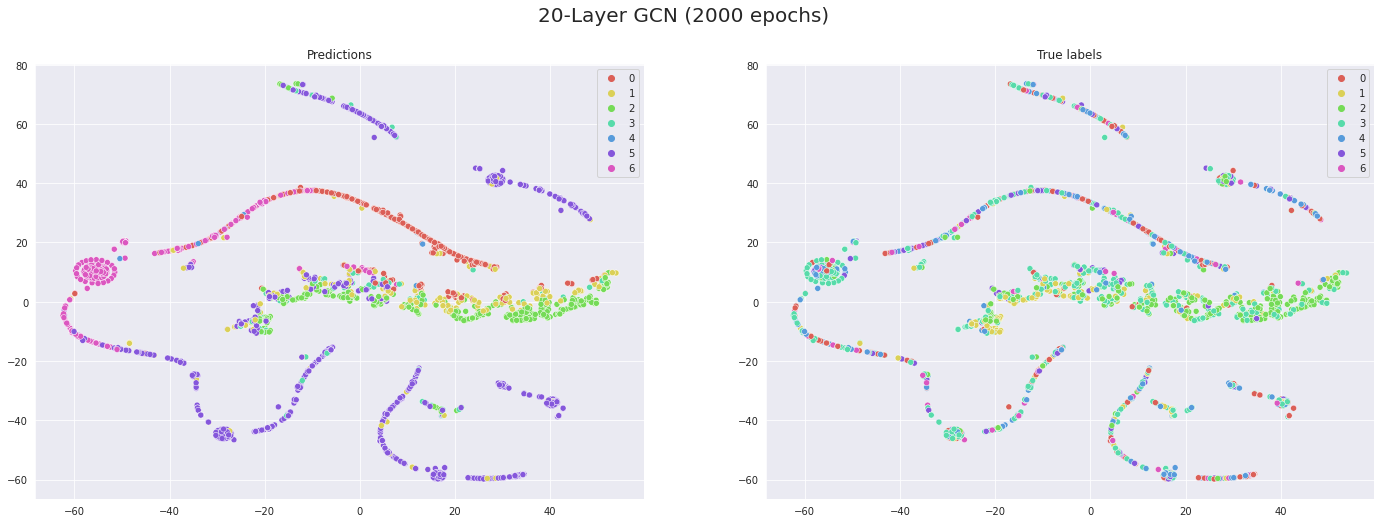

In [ ]:
tsne_plot(model, title=f"{NUM_LAYERS}-Layer GCN ({EPOCHS} epochs)")

### Training an even deeper model

In [ ]:
NUM_LAYERS=30
HIDDEN_DIM=16
NUM_FEATURES=cora_dataset.num_features
NUM_CLASSES=cora_dataset.num_classes
EPOCHS=3000
LR=0.01
WEIGHT_DECAY=5e-4
EARLY_STOPPING=0
RUNS=1

In [ ]:
very_deep_gcn = VanillaGCN(num_layers=NUM_LAYERS, hidden_dim=HIDDEN_DIM, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

In [ ]:
train_losses, test_accs, feat_dists = run(data=G, model=very_deep_gcn, edge_index=G.edge_index,
                                          runs=RUNS, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY,
                                          early_stopping=EARLY_STOPPING, verbose=False)

Val Loss: 1.7971, Test Accuracy: 0.208 ± nan, Duration: 1600.874


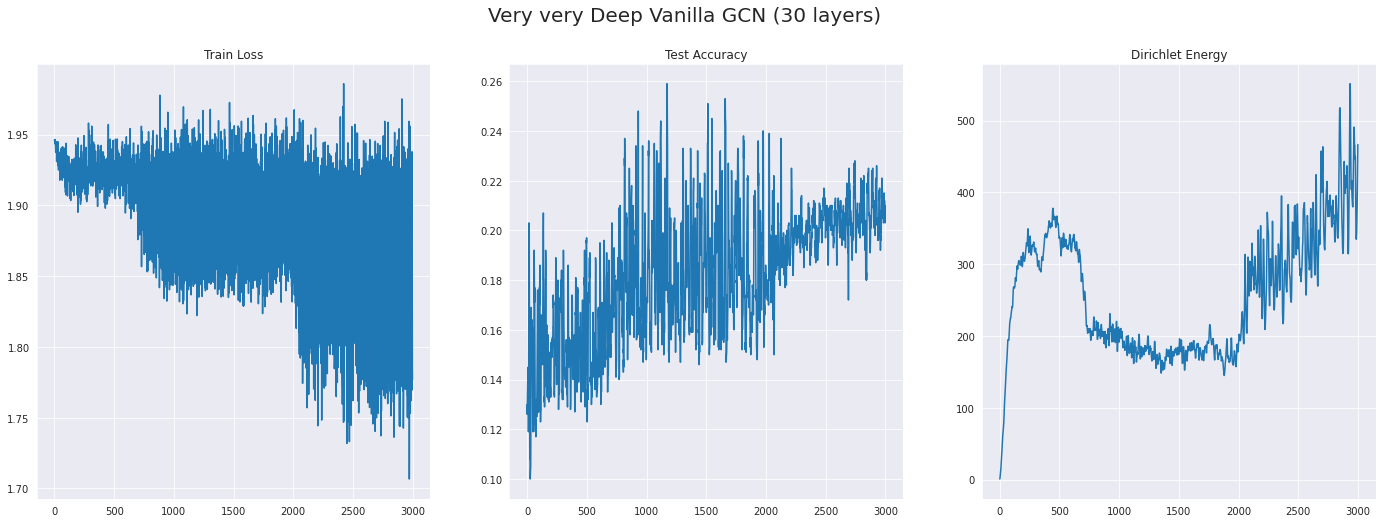

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

fig.suptitle(f"Very very Deep Vanilla GCN ({NUM_LAYERS} layers)", fontsize=20)

sns.lineplot(x=range(EPOCHS), y=train_losses, ax=ax[0]).set(title="Train Loss")
sns.lineplot(x=range(EPOCHS), y=test_accs, ax=ax[1]).set(title="Test Accuracy")
sns.lineplot(x=range(EPOCHS), y=feat_dists, ax=ax[2]).set(title="Dirichlet Energy")

fig.show()

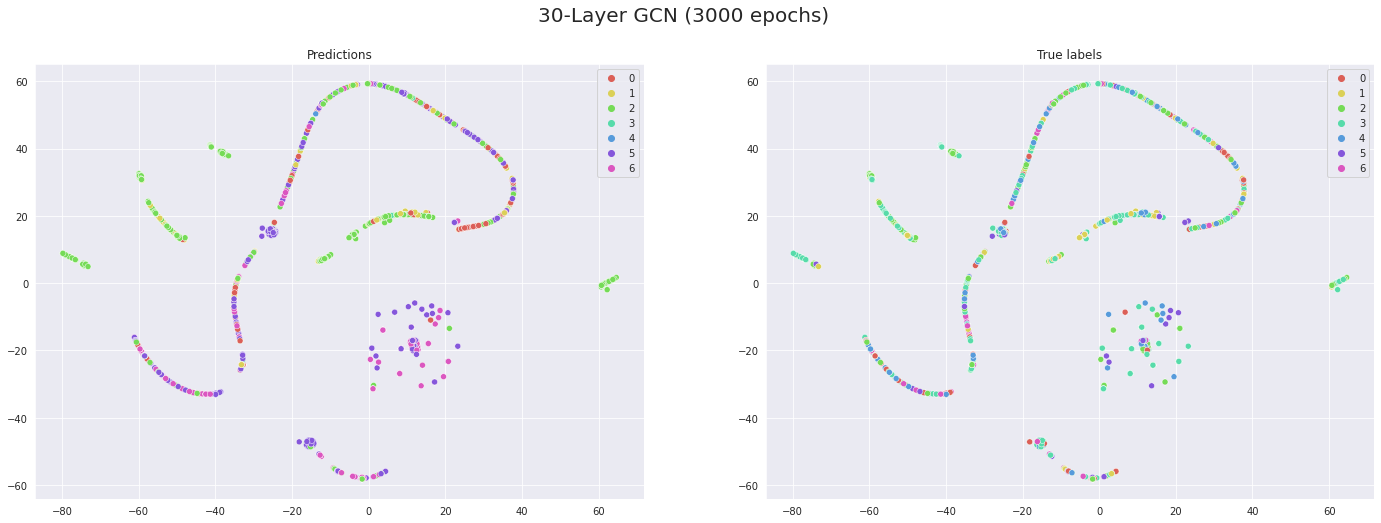

In [ ]:
tsne_plot(very_deep_gcn, title=f"{NUM_LAYERS}-Layer GCN ({EPOCHS} epochs)")

The adjacency matrix have an eigenspace for the value 1 of size 74 which means that we can **pick 16 columns from the 74 eigenvectors to form a steady state H**
<br/>
→ I need to pick real vectors!

In [ ]:
eigenvectors[eigenvalues == 1][:16].transpose().shape

(2708, 16)

In [ ]:
eigenvectors[eigenvalues == 1][np.isreal(eigenvectors[eigenvalues == 1].sum(1))].shape

(3, 2708)

So we can actually only pick from 3 different eigenvectors

In [ ]:
((np.matmul(
    A.numpy(),
    eigenvectors[eigenvalues == 1][10:26].transpose()
).squeeze(0) - (eigenvectors[eigenvalues == 1][10:26].transpose()))**2).mean()

(0.0019189814+8.298035e-07j)

In [ ]:
np.real(np.matmul(
    A.numpy(),
    eigenvectors[eigenvalues == 1][10:26].transpose()
).squeeze(0))

array([[ 4.1054506e-03,  1.6527642e-02,  2.2589374e-02, ...,
         1.0022904e-02,  7.4036131e-03, -1.0888007e-02],
       [-4.2850962e-03,  6.0773518e-02, -2.9292912e-03, ...,
         1.0843759e-02,  9.5979655e-03, -1.6141697e-03],
       [-3.8992748e-02,  1.0765143e-02, -4.8442323e-02, ...,
         3.6258113e-02,  9.4719594e-03, -2.6286094e-02],
       ...,
       [ 1.3058328e-02,  4.3770287e-02,  4.2025782e-03, ...,
         6.1039724e-03,  1.6665692e-02,  4.2273784e-03],
       [ 8.7983105e-03,  3.2962233e-02, -6.1229877e-03, ...,
        -2.2779889e-02,  2.6560232e-02, -5.7119932e-03],
       [ 2.3243956e-02,  1.6995415e-02,  6.0630962e-05, ...,
         2.4302155e-02, -8.5061044e-04, -6.1839642e-03]], dtype=float32)

## **Oversmoothing by comparison with the steady state**

We are going to compare the steady state:
$$
\hat{\tilde A}H = H
$$

In [ ]:
adj = G.edge_index
A = to_dense_adj(adj)
A.shape

torch.Size([1, 2708, 2708])

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(A.squeeze(0))

In [ ]:
# first we want 1 to be an eigen value
eigenvectors[eigenvalues == 1].shape

(74, 2708)

Reaching steady state by iteration (training a very deep model)

In [15]:
converged_model = VanillaGCN(num_layers=20, hidden_dim=config['hidden_dim'],
                             num_features=config['num_features'],
                             num_classes=config['num_classes'])

In [ ]:
run(data=G, model=converged_model,
    edge_index=G.edge_index, runs=1,
    epochs=1000, lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    early_stopping=config['early_stopping'],
    verbose=True)

In [19]:
h, out = converged_model(edge_index=G.edge_index, x=G.x)

In [29]:
mad_value(h.detach().numpy(), np.ones((A.shape)))

0.1843

In [27]:
mad_gap_value(h.detach().numpy(), A)

0.09277787804603577

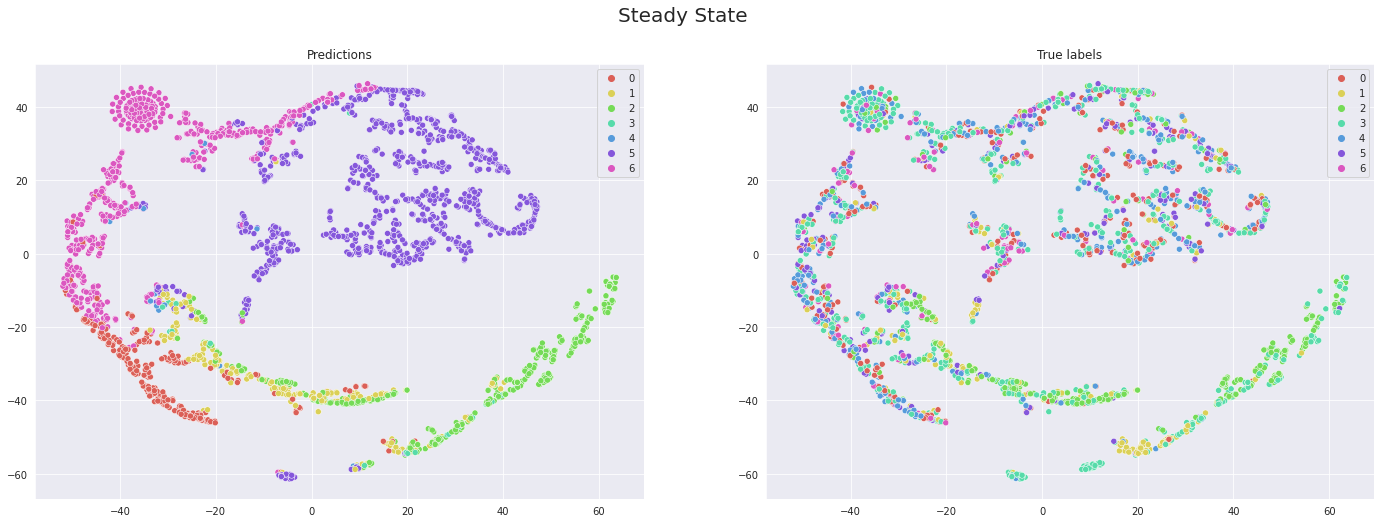

In [33]:
tsne_plot(model=converged_model, title="Steady State")

## **Updated MAD with shortest path weights**

In [36]:
import networkx as nx
from torch_geometric.utils import to_networkx

In [82]:
def get_shortest_path_lengths():
    g = to_networkx(G)
    shortest_paths = nx.shortest_path_length(g)

    sp_matrix = torch.zeros((G.num_nodes, G.num_nodes), dtype=int)

    for node_idx, path_lengths in shortest_paths:
        for (idx, len) in path_lengths.items():
            sp_matrix[node_idx, idx] = len
    
    return sp_matrix

In [84]:
shortest_path_lens = get_shortest_path_lengths()

In [114]:
mad_value(in_arr=h.detach().numpy(),
          mask_arr=torch.where(shortest_path_lens == 0, torch.tensor(0, dtype=torch.float32), 1/shortest_path_lens))

tensor(0.0362)

In [248]:
def shortest_path_mad(in_arr, shortest_paths):
    """Computes MAD of all node with shortest path normalization

    Args:
        - h [num_nodes, num_nodes]: representation matrix
        - shortest_paths [num_nodes, num_nodes]: matrix of shortest path lengths
    """
    
    return mad_value(in_arr=in_arr,
                     mask_arr=torch.where(shortest_paths == 0, torch.tensor(0, dtype=torch.float32), 1/shortest_paths**2))

### **Test: MADSP across layers**

In [116]:
from functools import partial

In [211]:
class Metric():
    def __init__(self, metric, layer, values):
        self.metric = metric
        self.layer = layer
        self.values = values
    
    def __call__(self, x: torch.Tensor, mode:str):
        if mode == "eval":
            idx = len(self.values)
            self.values.loc[idx] = {'layer':self.layer, 'value':metric(x)}
        return x

In [207]:
class VanillaGCN(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, num_classes:int, metric:Metric, dropout:float=0.5):
        super().__init__()
        self.metric = metric
        self.values = pd.DataFrame(columns=['layer', 'value'])
        self.conv_layers = self.create_layers(num_layers=num_layers, 
                                              num_features=num_features,
                                              num_classes=num_classes,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout)
        self.out_gcn = GCNConv(in_channels=hidden_dim, out_channels=num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)


    def create_layers(self, num_layers:int, num_features:int, num_classes:int, 
                      hidden_dim:int, dropout:float):
        if num_layers == 2:
            return Sequential("x, edge_index, mode",
                              [(GCNConv(in_channels=num_features, out_channels=hidden_dim), "x, edge_index -> x"),
                               (Metric(metric=self.metric, layer=1, values=self.values), "x, mode -> x")])

        layers = []

        # first layer
        layers += [
                (GCNConv(in_channels=num_features, out_channels=hidden_dim), "x, edge_index -> x"),
                (Metric(metric=self.metric, layer=1, values=self.values), "x, mode -> x"),
                (torch.nn.ReLU(), "x -> x"),
                (torch.nn.Dropout(p=dropout), "x -> x")
        ]

        for k in range(1, num_layers-2):
            layers += [
                (GCNConv(in_channels=hidden_dim, out_channels=hidden_dim), "x, edge_index -> x"),
                (Metric(metric=self.metric, layer=k+1, values=self.values), "x, mode -> x"),
                (torch.nn.ReLU(), "x -> x"),
                (torch.nn.Dropout(p=dropout), "x -> x")
            ]
        
        # last layer
        layers += [
            (GCNConv(in_channels=hidden_dim, out_channels=hidden_dim), "x, edge_index -> x"),
            (Metric(metric=self.metric, layer=num_layers-1, values=self.values), "x, mode -> x"),
        ]
        return Sequential("x, edge_index, mode", layers)


    def reset_parameters(self):
        self.conv_layers.reset_parameters()
        # self.out_gcn.reset_parameters()


    def forward(self, x, edge_index):
        mode = 'train' if self.training else 'eval'
        h = self.conv_layers(x, edge_index, mode)
        out = self.relu(h)
        out = self.dropout(out)
        out = self.out_gcn(out, edge_index)
        
        return h, self.log_softmax(out)

In [249]:
metric = partial(shortest_path_mad, shortest_paths=shortest_path_lens)

In [250]:
model = VanillaGCN(num_layers=2,
                   hidden_dim=config['hidden_dim'],
                   num_features=config['num_features'],
                   num_classes=config['num_classes'],
                   metric=metric)

In [ ]:
run(data=G, model=model,
    edge_index=G.edge_index, runs=1,
    epochs=300, lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    early_stopping=config['early_stopping'],
    verbose=False)

In [254]:
# clean values during training
model.values.drop(model.values.index, inplace=True)
evaluate(model, data=G, edge_index=G.edge_index)
model.values

,layer,value
0,1,tensor(0.0122)


In [255]:
def mad_value(in_arr, mask_arr, distance_metric='cosine'):
    """The numpy version for mad (able to compute quickly)

    Args:
        - in_arr [node_num, hidden_dim]: the node feature matrix
        - mask_arr [node_num, node_num]: the mask matrix of the target relations (is it the adjacency matrix?)
        - target_idx [1, 2, 3, ...n]: the nodes indices for which we calculate the mad value
    """

    dist_arr = pairwise_distances(in_arr, in_arr, metric=distance_metric)
    mask_dist = np.multiply(dist_arr, mask_arr)
    divide_arr = (mask_dist != 0).sum(1) + 1e-8
    
    node_dist = mask_dist.sum(1) / divide_arr

    return node_dist

In [265]:
def shortest_path_mad(in_arr, shortest_paths):
    """Computes MAD of all node with shortest path normalization

    Args:
        - h [num_nodes, num_nodes]: representation matrix
        - shortest_paths [num_nodes, num_nodes]: matrix of shortest path lengths
    """
    
    return mad_value(in_arr=in_arr,
                     mask_arr=torch.where(shortest_paths == 0, torch.tensor(0, dtype=torch.float32), 1/shortest_paths))

In [266]:
model.eval()
with torch.no_grad():
    h, logits = model(G.x, edge_index=G.edge_index)
mad_sp_values = shortest_path_mad(h, shortest_path_lens)

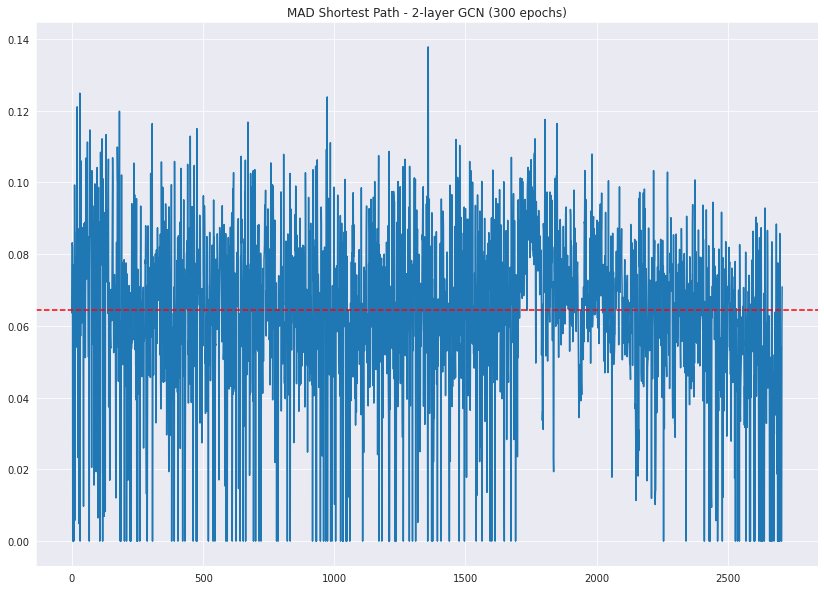

In [276]:
plt.figure(figsize=(14, 10))
sns.lineplot(x=range(G.num_nodes), y=mad_sp_values).set(title='MAD Shortest Path - 2-layer GCN (300 epochs)')
plt.axhline(0.0644, c='red', ls='--')

In [234]:
model = VanillaGCN(num_layers=7,
                   hidden_dim=config['hidden_dim'],
                   num_features=config['num_features'],
                   num_classes=config['num_classes'],
                   metric=metric)

In [235]:
evaluate(model, data=G, edge_index=G.edge_index)

{'feat_dist': 0.22407737374305725,
 'mad': 0.0234,
 'mad_gap': 0.021921265870332718,
 'test_acc': 0.083,
 'test_loss': 1.94578218460083,
 'train_acc': 0.1,
 'train_loss': 1.9468504190444946,
 'val_acc': 0.1,
 'val_loss': 1.9451810121536255}

In [236]:
model.values

,layer,value
0,1,tensor(0.1332)
1,2,tensor(0.0778)
2,3,tensor(0.0284)
3,4,tensor(0.0126)
4,5,tensor(0.0083)
5,6,tensor(0.0026)


In [ ]:
run(data=G, model=model,
    edge_index=G.edge_index, runs=1,
    epochs=1000, lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    early_stopping=config['early_stopping'],
    verbose=False)

In [238]:
# clean values during training
model.values.drop(model.values.index, inplace=True)

In [239]:
evaluate(model, data=G, edge_index=G.edge_index)

{'feat_dist': 80044.4453125,
 'mad': 0.8215,
 'mad_gap': 0.7663748860359192,
 'test_acc': 0.708,
 'test_loss': 2.511240243911743,
 'train_acc': 1.0,
 'train_loss': 0.012692245654761791,
 'val_acc': 0.69,
 'val_loss': 2.811328411102295}

In [240]:
model.values

,layer,value
0,1,tensor(0.1300)
1,2,tensor(0.1324)
2,3,tensor(0.1387)
3,4,tensor(0.1363)
4,5,tensor(0.1321)
5,6,tensor(0.1246)


In [ ]:
run(data=G, model=model,
    edge_index=G.edge_index, runs=1,
    epochs=5000, lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    early_stopping=config['early_stopping'],
    verbose=False)

In [244]:
# clean values during training
model.values.drop(model.values.index, inplace=True)
_ = evaluate(model, data=G, edge_index=G.edge_index)
model.values

,layer,value
0,1,tensor(0.0736)
1,2,tensor(0.1289)
2,3,tensor(0.1477)
3,4,tensor(0.1397)
4,5,tensor(0.1276)
5,6,tensor(0.1354)


# **END**